# Training Data

In [27]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

NotFoundError: /home/oles/.local/lib/python3.10/site-packages/tensorflow_decision_forests/tensorflow/ops/inference/inference.so: undefined symbol: _ZN10tensorflow20OpKernelConstruction21CtxFailureWithWarningEPKciRKN4absl12lts_202308026StatusE

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Create tensorflow dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CatBreedData",
    batch_size = BATCH_SIZE
)

Found 7000 files belonging to 20 classes.


2025-01-15 21:49:12.758483: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2025-01-15 21:49:12.758510: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: oles-linux
2025-01-15 21:49:12.758516: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: oles-linux
2025-01-15 21:49:12.758570: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2025-01-15 21:49:12.758591: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2025-01-15 21:49:12.758596: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.171.4 does not match DSO version 535.183.1 -- cannot find working devices in this configuration


### Resize training images

In [4]:
class_names = dataset.class_names

In [5]:
def resize_images(image, label):
    resized_image = tf.image.resize(image, (256, 256))
    return resized_image, label

# Map the resize function to the dataset
dataset = dataset.map(resize_images)

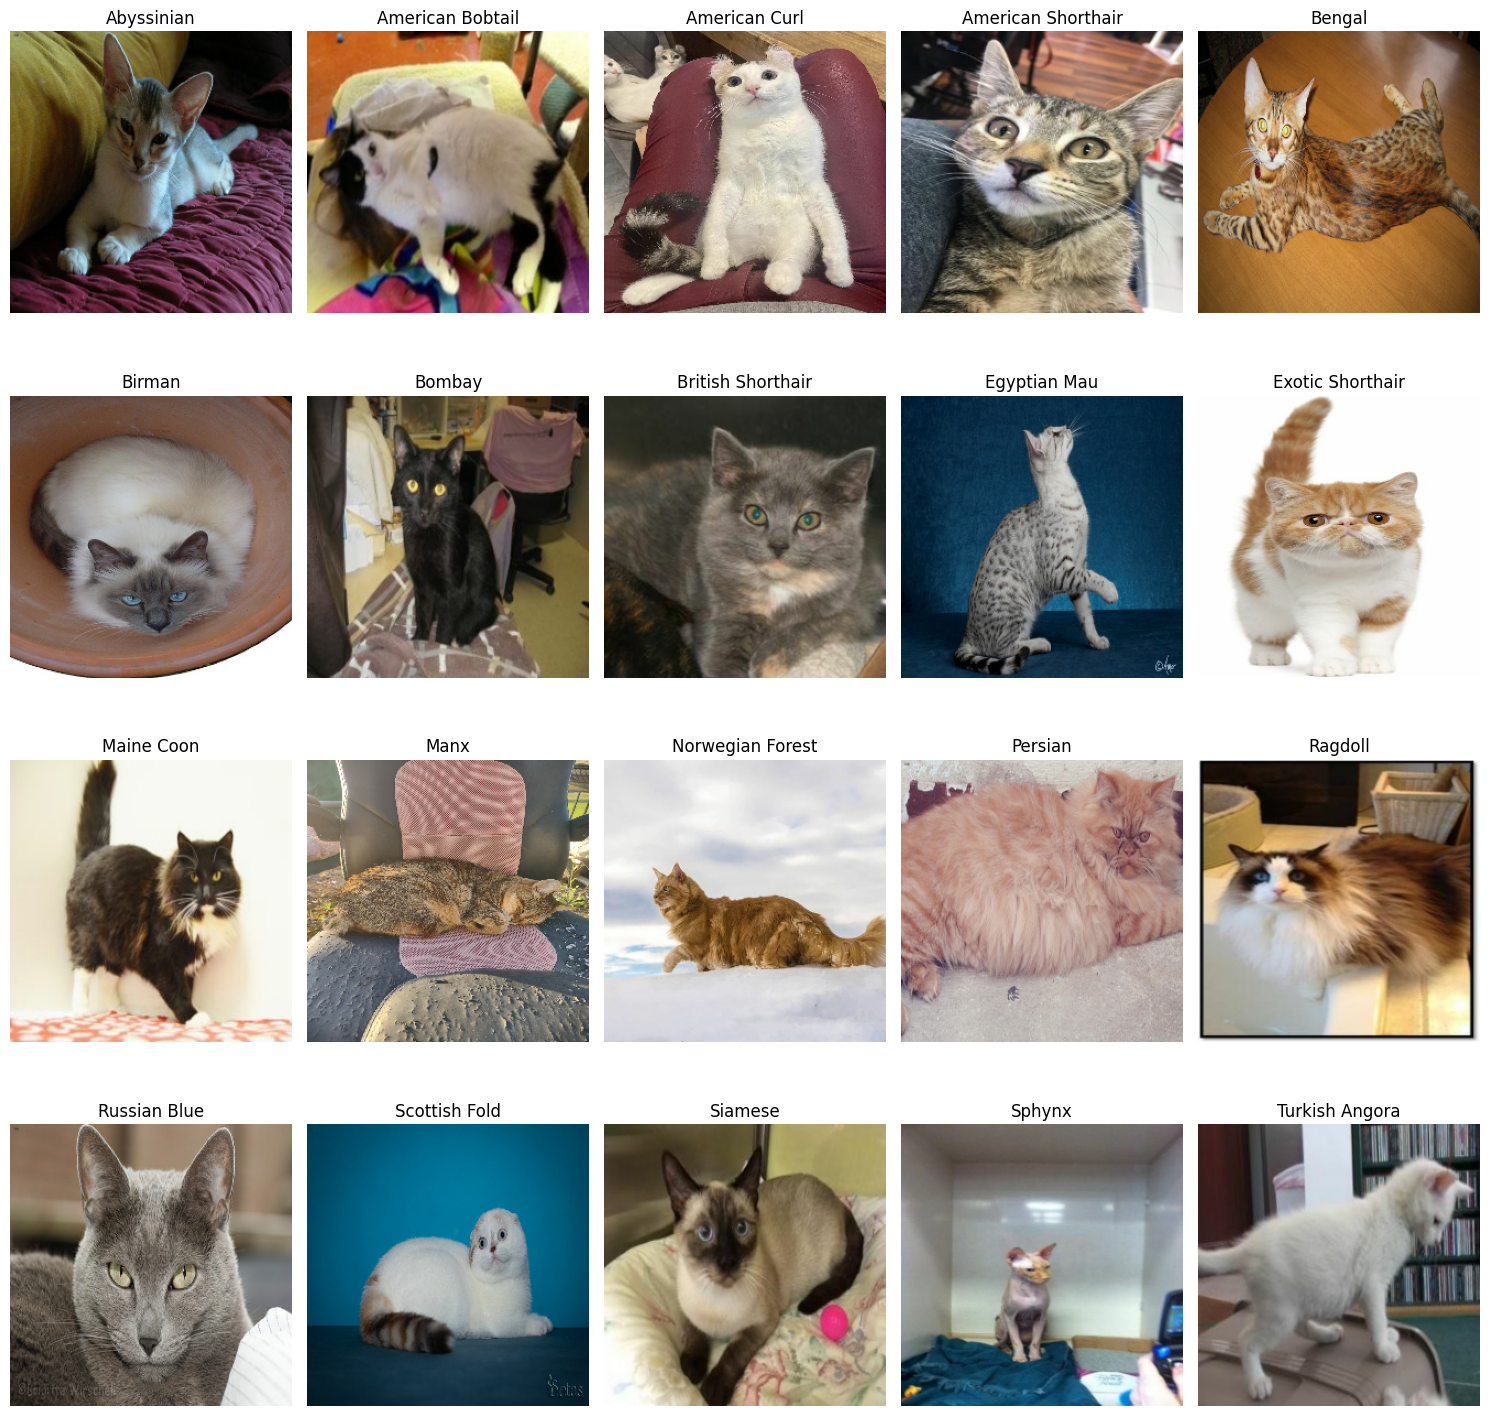

In [6]:
import matplotlib.pyplot as plt

# Assuming there are 20 classes
num_classes = 20

# Create a list to track if an image has been displayed for each class
image_displayed = [False] * num_classes

plt.figure(figsize=(15, 15))

for image_batch, label_batch in dataset:
    for i in range(len(image_batch)):
        label = label_batch[i].numpy()
        if not image_displayed[label]:
            ax = plt.subplot(4, 5, label + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label])
            plt.axis("off")
            image_displayed[label] = True

        # Check if we have displayed one image per class
        if all(image_displayed):
            break

    # Check if we have displayed one image per class
    if all(image_displayed):
        break

plt.tight_layout()
plt.show()



In [7]:
len(dataset)*0.8

175.20000000000002

### Partition dataset into training, validation, and testing

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data augmentation

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

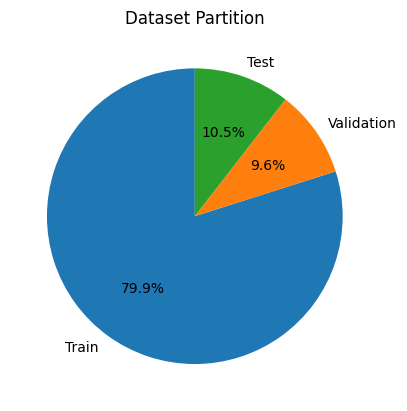

In [13]:
import matplotlib.pyplot as plt

# Assuming you have the dataset split into train, validation, and test sets
labels = ['Train', 'Validation', 'Test']
sizes = [len(train_ds), len(val_ds), len(test_ds)]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Partition')
plt.show()

### Create Convolutional Neural Network Model

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Your model definition
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(20, activation='softmax')
])

# Create a subplot with 1 row and 1 column
fig = make_subplots(rows=1, cols=1)

# Add shapes for different layers
shapes = []
layer_names = ["Conv2D", "MaxPooling2D", "Conv2D", "MaxPooling2D", "Conv2D", "MaxPooling2D",
               "Conv2D", "MaxPooling2D", "Conv2D", "MaxPooling2D", "Conv2D", "MaxPooling2D", "Flatten", "Dense"]

# Define y-coordinates for each layer
y_coords = [1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1]

for i, layer_name in enumerate(layer_names):
    if "Conv2D" in layer_name:
        shapes.append(
            dict(
                type="rect",
                x0=i + 1,
                x1=i + 2,
                y0=y_coords[i],
                y1=y_coords[i] + 1,
                fillcolor="blue",
                opacity=0.7,
                layer="below",
                line=dict(width=0),
            )
        )
    elif "MaxPooling2D" in layer_name:
        shapes.append(
            dict(
                type="rect",
                x0=i + 1,
                x1=i + 2,
                y0=y_coords[i],
                y1=y_coords[i] + 1,
                fillcolor="orange",
                opacity=0.7,
                layer="below",
                line=dict(width=0),
            )
        )
    elif "Flatten" in layer_name:
        shapes.append(
            dict(
                type="rect",
                x0=i + 1,
                x1=i + 2,
                y0=y_coords[i],
                y1=y_coords[i] + 1,
                fillcolor="green",
                opacity=0.7,
                layer="below",
                line=dict(width=0),
            )
        )
    elif "Dense" in layer_name:
        shapes.append(
            dict(
                type="rect",
                x0=i + 1,
                x1=i + 2,
                y0=y_coords[i],
                y1=y_coords[i] + 1,
                fillcolor="purple",
                opacity=0.7,
                layer="below",
                line=dict(width=0),
            )
        )

# Add lines and annotations for relationships and labels
for i in range(len(layer_names) - 1):
    fig.add_trace(
        go.Scatter(
            x=[i + 1, i + 2],
            y=[y_coords[i] + 0.5, y_coords[i + 1] + 0.5],
            mode="lines",
            line=dict(color="black", width=2),
        )
    )

    fig.add_annotation(
        go.layout.Annotation(
            x=i + 1.5,
            y=(y_coords[i] + y_coords[i + 1]) / 2 + 0.5,
            xref="x",
            yref="y",
            text=f"{layer_names[i]}",
            showarrow=False,
            font=dict(color="black"),
        )
    )

fig.update_layout(shapes=shapes)

# Update layout for better visualization
fig.update_layout(
    showlegend=False,
    title_text="Kitty Classifier CNN Diagram",
    title_x=0.5,
    xaxis_title="Layers",
    yaxis_title="",
    yaxis_showticklabels=False,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
)

# Show the plot
fig.show()



### Model Compilation

Using adam optimizer

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  0
TensorFlow version: 2.15.0


In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
175/175 [==============================] - 132s 727ms/step - loss: 2.9838 - accuracy: 0.0607 - val_loss: 2.9242 - val_accuracy: 0.0994
Epoch 2/20
175/175 [==============================] - 123s 700ms/step - loss: 2.8808 - accuracy: 0.1089 - val_loss: 2.8087 - val_accuracy: 0.1235
Epoch 3/20
175/175 [==============================] - 123s 702ms/step - loss: 2.7899 - accuracy: 0.1382 - val_loss: 2.7367 - val_accuracy: 0.1596
Epoch 4/20
175/175 [==============================] - 123s 701ms/step - loss: 2.6864 - accuracy: 0.1766 - val_loss: 2.6546 - val_accuracy: 0.1973
Epoch 5/20
175/175 [==============================] - 123s 702ms/step - loss: 2.5791 - accuracy: 0.2050 - val_loss: 2.4624 - val_accuracy: 0.2259
Epoch 6/20
175/175 [==============================] - 122s 700ms/step - loss: 2.4552 - accuracy: 0.2380 - val_loss: 2.3904 - val_accuracy: 0.2590
Epoch 7/20
175/175 [==============================] - 123s 705ms/step - loss: 2.3378 - accuracy: 0.2711 - val_loss: 2.1336 -

In [23]:
scores = model.evaluate(test_ds)

23/23 [==============================] - 5s 206ms/step - loss: 1.5607 - accuracy: 0.8234


### Plotting Data

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Siamese
1/1 [==============================] - 0s 164ms/step
[9.11082498e-09 9.18745002e-07 1.36346371e-05 6.36431359e-05
 1.94304022e-08 2.06671146e-04 1.94385289e-11 1.87309168e-09
 1.15002594e-08 5.19103105e-06 1.79448477e-07 1.98051538e-02
 8.32103433e-06 3.77286508e-10 4.37632771e-05 9.66071251e-11
 1.14802376e-10 9.73896503e-01 5.95047744e-03 5.46426463e-06]
predicted label: Siamese


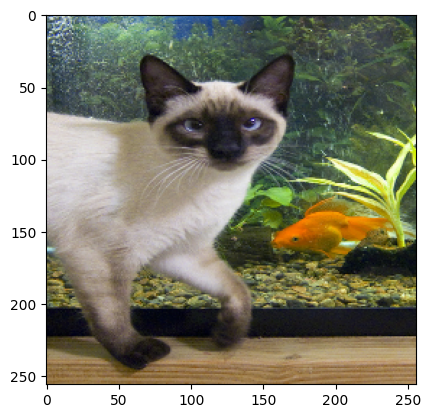

In [21]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


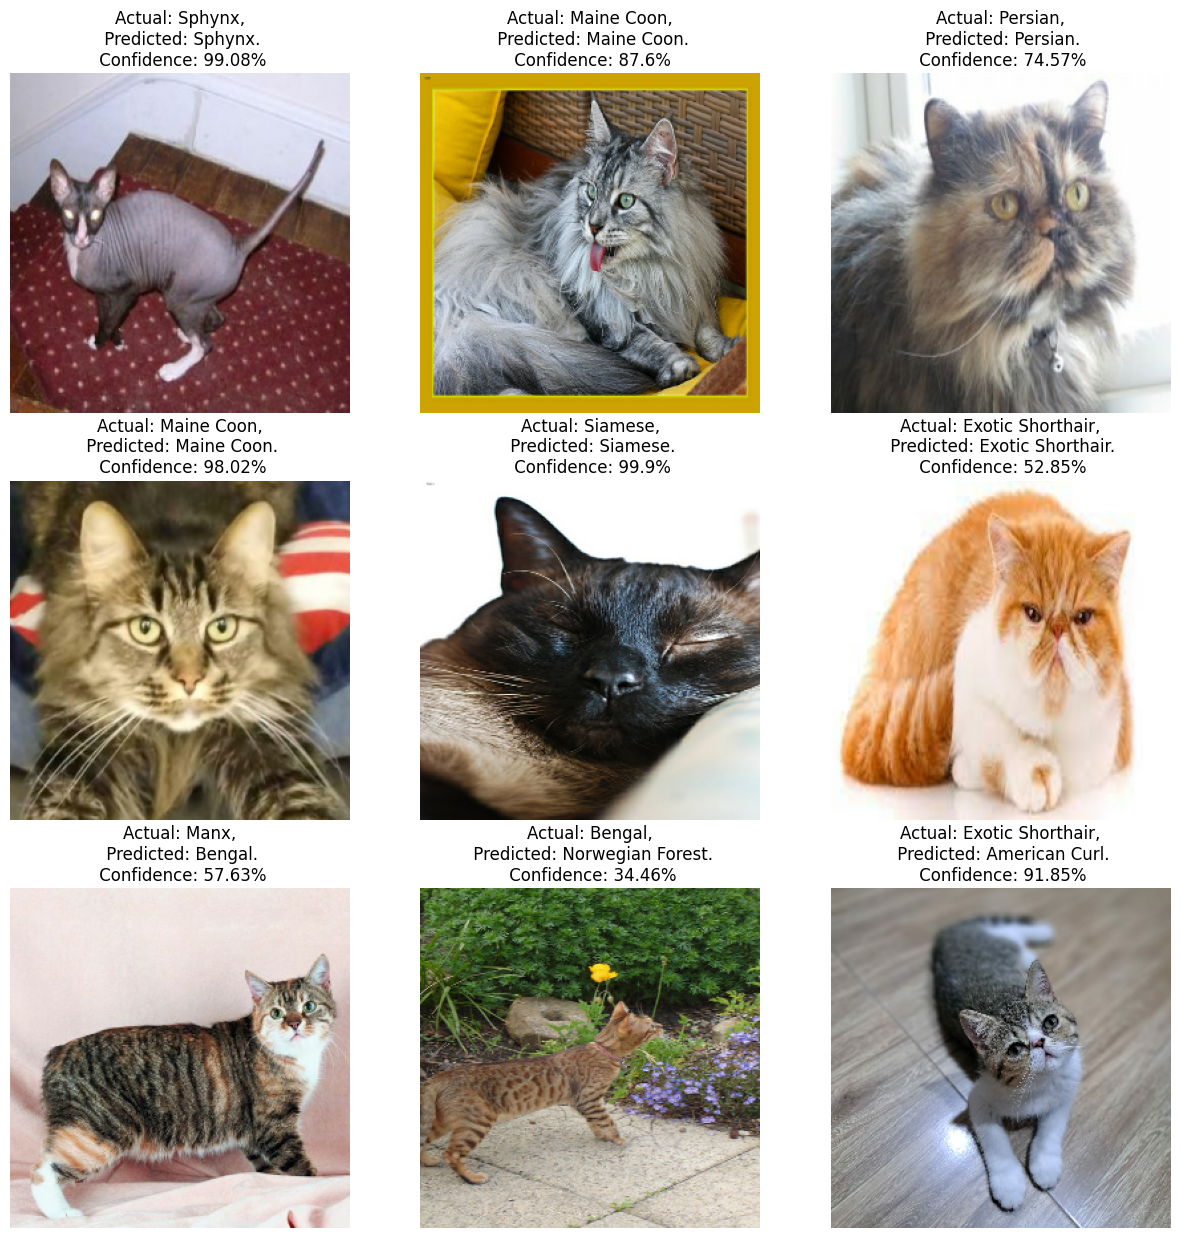

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [24]:
model.save("../cats79.h5")

/home/oles/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
my_list = [4.2312220e-02, 3.1525540e-01, 8.6432882e-03, 5.7903726e-02, 7.1580554e-03, 1.5214826e-04, 1.8854050e-01, 9.3365029e-02, 8.5842106e-03, 4.0058005e-03, 1.7474035e-02, 8.9599015e-03, 6.1395657e-03, 4.6511076e-02, 2.2487075e-03, 9.5908634e-02, 1.1547348e-02, 2.4916488e-04, 1.7835747e-02, 6.7205392e-02]

max_index = np.argmax(my_list)

print("Index of the maximum value:", max_index)

Index of the maximum value: 1
